7. Побудувати CNN на основі Xception для класифікації зображень на основі
датасету fashion-mnist.
Зробити налаштування моделі для досягнення необхідної точності. На базі
Siamese networks побудувати систему для пошуку подібних зображень в
датасеті fashion-mnist. Візуалізувати отримані результати t-SNE.

*   Методичка - https://drive.google.com/drive/u/2/folders/1JiVuXf_dHKRLb0SR045Kw9GeeVco2xNf
*   Теорія - https://towardsdatascience.com/illustrated-10-cnn-architectures-95d78ace614d

# Завантаження, аналіз та препроцесінг даних

В основі класифікації (для пошуку подібних ) зображень пропонується використовувати Siamese
networks. Ідея складається в тому щоб взяти випадково ініціалізовану мережу і застосувати її до
зображень, щоб дізнатися наскільки вони схожі. Модель має значно полегшати виконання таких
задач, як візуальний пошук по базі даних зображень, так як вона буде мати просту метрику
подібності між 0 та 1 замість 2D масивів.

In [101]:
# IMPORTS

import os

import pandas as pd

import numpy as np
import random

from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

import tensorflow_datasets as tfds
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

tf.config.run_functions_eagerly(True)

In [102]:
# GET DATA

fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [104]:
# SHAPES

print("train_images: " + str(train_images.shape))
print("train_labels: " + str(train_labels.shape))

print("\ntest_images: " + str(test_images.shape))
print("test_labels: " + str(test_labels.shape))

train_images: (60000, 28, 28)
train_labels: (60000,)

test_images: (10000, 28, 28)
test_labels: (10000,)


Label: 9
Shape: (28, 28)
Image:


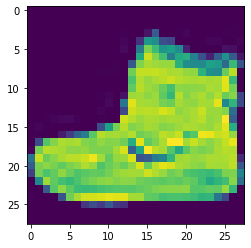

In [105]:
# IMAGE EXAMPLE

print("Label: " + str(train_labels[0]))
print("Shape: " + str(train_images[0].shape))

print("Image:")
plt.imshow(train_images[0])
plt.show()

In [106]:
# MORM I

print("Before norm: " + str(train_images[0][23]))

train_images = train_images / 255.0
test_images = test_images / 255.0

print("After norm: " + str(train_images[0][23]))

Before norm: [  0   0  74 189 212 191 175 172 175 181 185 188 189 188 193 198 204 209
 210 210 211 188 188 194 192 216 170   0]
After norm: [0.         0.         0.29019608 0.74117647 0.83137255 0.74901961
 0.68627451 0.6745098  0.68627451 0.70980392 0.7254902  0.7372549
 0.74117647 0.7372549  0.75686275 0.77647059 0.8        0.81960784
 0.82352941 0.82352941 0.82745098 0.7372549  0.7372549  0.76078431
 0.75294118 0.84705882 0.66666667 0.        ]


In [107]:
# CHECK GROUPS

print("Unique labels: " + str(np.unique(test_labels)))
print("Unique labels count: " + str(len(np.unique(test_labels))))

Unique labels: [0 1 2 3 4 5 6 7 8 9]
Unique labels count: 10


# GLOBAL VARS

In [109]:
# GLOBAL VARS

CLASSES = len(np.unique(test_labels))
EPOCH = 3        #17
BS = 128   

img_shape =  np.concatenate((test_images[1].shape, [1]))

In [110]:
print("img_shape: " + str(img_shape))

img_shape: [28 28  1]


#Preprocessing - create pairs dataset


Ідея полягає в тому, щоб зробити батчі для навчання мережі для прискорення процесу навчання з
мінімізацією втрат по якості. Для цього потрібно створити паралельні входи для зображень A і B, де
виходом є відстань. Припускаємо, що якщо зображення знаходяться в одній групі, то їх схожість
дорівнює 1, в іншому випадку - 0.
Якщо випадковим чином вибрати усі зображення, то, швидше за все, отримаємо більшість
зображень в різних групах.

In [111]:
# CREATE PAIRS 

def create_pairs(x, digit_indices):
    '''
      Positive and negative pair creation.
      Alternates between positive and negative pairs.
    '''

    pairs = []
    labels = []
    n = []

    for d in range(CLASSES):
      n.append(len(digit_indices[d])) 
    n = min(n) - 1


    for d in range(CLASSES):
        for i in range(n):

            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]  # FROM ONE GROUP
            pairs += [[x[z1], x[z2]]]

            dn = (d + random.randrange(1, CLASSES)) % CLASSES

            z1, z2 = digit_indices[d][i], digit_indices[dn][i]     # FROM DIFFERENT GROUPS
            pairs += [[x[z1], x[z2]]]

            labels += [1, 0]
    
    return np.array(pairs), np.array(labels)

In [112]:
#TEST PAIRS CREATION

testPairs = [[] for i in range(CLASSES)]

testPairs[0] = [0, 1] # INDEXIS IN GROUPS
testPairs[1] = [0, 1]
testPairs[2] = [0, 1]
testPairs[3] = [0, 1]
testPairs[4] = [0, 1]
testPairs[5] = [0, 1]
testPairs[6] = [0, 1]
testPairs[7] = [0, 1]
testPairs[8] = [0, 1]
testPairs[9] = [0, 1]

pairTupleImage, pairTupleLabel = create_pairs(test_images, testPairs)

print("pairTupleImage shape: " + str(pairTupleImage.shape))
print("pairTupleLabel shape: " + str(pairTupleLabel.shape))

pairTupleImage shape: (20, 2, 28, 28)
pairTupleLabel shape: (20,)


In [ ]:
# MAKE PAIR DATASET

def make_pair_dataset(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(CLASSES)]

    pairs, y = create_pairs(images, digit_indices)

    return pairs, y

In [113]:
# CHECK SHAPES

pairTupleImage, pairTupleLabel = make_pair_dataset(test_images, test_labels)

print("pairTupleImage shape: " + str(pairTupleImage.shape))
print("pairTupleLabel shape: " + str(pairTupleLabel.shape))

pairTupleImage shape: (19980, 2, 28, 28)
pairTupleLabel shape: (19980,)


In [114]:
# CHECK SHAPES

tr_pairs, tr_y = make_pair_dataset(train_images, train_labels)

print("Train pairs shape: " + str(tr_pairs.shape))
print("Train label shape: " + str(tr_y.shape))


te_pairs, te_y = make_pair_dataset(test_images, test_labels)

print("\nTest pairs shape: " + str(te_pairs.shape))
print("Test label shape: " + str(te_y.shape))

Train pairs shape: (119980, 2, 28, 28)
Train label shape: (119980,)

Test pairs shape: (19980, 2, 28, 28)
Test label shape: (19980,)


In [115]:
# CHANGE TYPE FOR FUTURE CORRECT PREDICTION

tr_y = tr_y.astype(np.float32)
te_y = te_y.astype(np.float32)

In [116]:
# SPLIT

x_tra, x_val, y_tra, y_val = train_test_split(tr_pairs, tr_y, test_size=0.2, stratify=tr_y, random_state=21)

In [117]:
# CHECK SHAPES

print('Training: ', x_tra.shape, x_tra.max())
print('Testing: ', te_pairs.shape, te_pairs.max())
print('Validation: ', x_val.shape, x_val.max())

Training:  (95984, 2, 28, 28) 1.0
Testing:  (19980, 2, 28, 28) 1.0
Validation:  (23996, 2, 28, 28) 1.0


In [118]:
# CHECK DIVISION

train_groups = [x_tra[np.where(y_tra==i)[0]] for i in np.unique(y_tra)]
test_groups = [te_pairs[np.where(te_y==i)[0]] for i in np.unique(te_y)]
val_groups = [x_val[np.where(y_val==i)[0]] for i in np.unique(y_val)]

print('Train true/false: ', [x.shape[0] for x in train_groups])
print('Test true/false: ', [x.shape[0] for x in test_groups])
print('Validation true/false: ', [x.shape[0] for x in val_groups])

Train true/false:  [47992, 47992]
Test true/false:  [9990, 9990]
Validation true/false:  [11998, 11998]


# Валідація даних

Не етапі валідації переконуємось, що генератор робить щось “розумне і правильне”. Для цього
виводяться зображення і відсоток їх подібності.

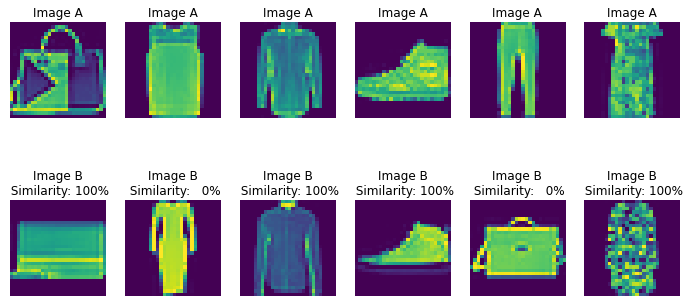

In [119]:
# CHECK CREATED PAIRS

testDataX = x_tra[:6]
testDataY = y_tra[:6]


fig, m_axs = plt.subplots(2, testDataX.shape[0], figsize = (12, 6))

for pair, label, (ax1, ax2) in zip(testDataX, testDataY, m_axs.T):
  
  ax1.imshow(pair[0])
  ax1.set_title('Image A')
  ax1.axis('off')
  
  ax2.imshow(pair[1])
  ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*label))
  ax2.axis('off')

# Генерація фічей (ознак) - Xception - feature model

Для генерації фічей з зображень будуємо конволюційну мережу. Мережа ініціалізується випадковим
чином і буде навчатись генерувати корисні вектори фічей з вхідних зображень.

***Xception (2016)***

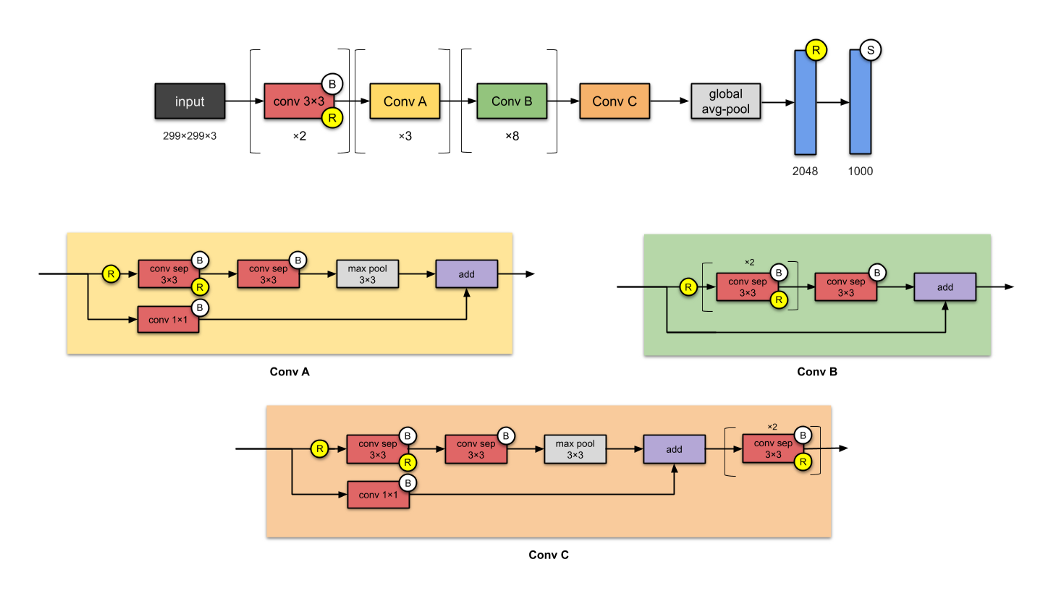

https://github.com/keras-team/keras-applications/blob/master/keras_applications/xception.py

Xception — це адаптація Inception, де модулі Inception були замінені на глибинно роздільні згортки. Він також має приблизно таку ж кількість параметрів, як і Inception-v1 ( 23M ).

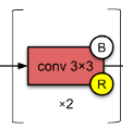

In [120]:
def block1(x, s = 2 , filters = (64, 128)):
  f1,f2 = filters
  
  x = tf.keras.layers.Conv2D(f1, (3, 3), strides=(s, s), use_bias=False, name='block1_conv1')(x)
  x = tf.keras.layers.BatchNormalization(name='block1_conv1_bn')(x)
  x = tf.keras.layers.Activation('relu', name='block1_conv1_act')(x)

  x = tf.keras.layers.Conv2D(f2, (3, 3), use_bias=False, name='block1_conv2')(x)
  x = tf.keras.layers.BatchNormalization(name='block1_conv2_bn')(x)
  x = tf.keras.layers.Activation('relu', name='block1_conv2_act')(x)

  return x

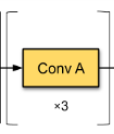

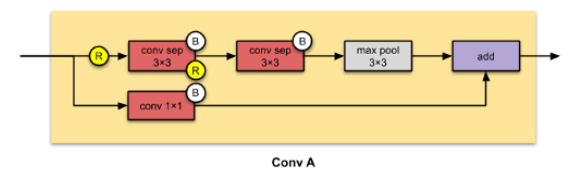

In [121]:
def blockA(x, s = 2):
  
  residual = tf.keras.layers.Conv2D(128, (1, 1), strides=(s, s), padding='same', use_bias=False)(x)
  residual = tf.keras.layers.BatchNormalization()(residual)


  x = tf.keras.layers.SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='block2_sepconv1')(x)
  x = tf.keras.layers.BatchNormalization(name='block2_sepconv1_bn')(x)

  x = tf.keras.layers.Activation('relu', name='block2_sepconv2_act')(x)
  x = tf.keras.layers.SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='block2_sepconv2')(x)
  x = tf.keras.layers.BatchNormalization(name='block2_sepconv2_bn')(x)

  x = tf.keras.layers.MaxPooling2D((3, 3), strides=(s, s), padding='same', name='block2_pool')(x)

  x = tf.keras.layers.add([x, residual])


  residual = tf.keras.layers.Conv2D(256, (1, 1), strides=(s, s), padding='same', use_bias=False)(x)
  residual = tf.keras.layers.BatchNormalization()(residual)


  x = tf.keras.layers.Activation('relu', name='block3_sepconv1_act')(x)
  x = tf.keras.layers.SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv1')(x)
  x = tf.keras.layers.BatchNormalization(name='block3_sepconv1_bn')(x)

  x = tf.keras.layers.Activation('relu', name='block3_sepconv2_act')(x)
  x = tf.keras.layers.SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv2')(x)
  x = tf.keras.layers.BatchNormalization(name='block3_sepconv2_bn')(x)

  x = tf.keras.layers.MaxPooling2D((3, 3), strides=(s, s), padding='same', name='block3_pool')(x)

  x = tf.keras.layers.add([x, residual])


  residual = tf.keras.layers.Conv2D(728, (1, 1),  strides=(s, s),  padding='same',  use_bias=False)(x)
  residual = tf.keras.layers.BatchNormalization()(residual)


  x = tf.keras.layers.Activation('relu', name='block4_sepconv1_act')(x)
  x = tf.keras.layers.SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv1')(x)
  x = tf.keras.layers.BatchNormalization(name='block4_sepconv1_bn')(x)

  x = tf.keras.layers.Activation('relu', name='block4_sepconv2_act')(x)
  x = tf.keras.layers.SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv2')(x)
  x = tf.keras.layers.BatchNormalization(name='block4_sepconv2_bn')(x)

  x = tf.keras.layers.MaxPooling2D((3, 3), strides=(s, s), padding='same', name='block4_pool')(x)

  x = tf.keras.layers.add([x, residual])

  return x

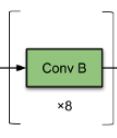

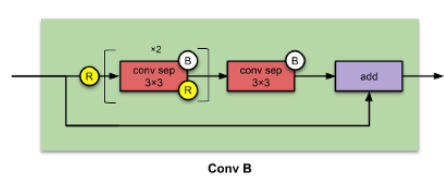

In [122]:
def blockB (x):
      for i in range(8):
        residual = x

        prefix = 'block' + str(i + 5)

        x = tf.keras.layers.Activation('relu', name=prefix + '_sepconv1_act')(x)
        x = tf.keras.layers.SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv1')(x)
        x = tf.keras.layers.BatchNormalization(name=prefix + '_sepconv1_bn')(x)

        x = tf.keras.layers.Activation('relu', name=prefix + '_sepconv2_act')(x)
        x = tf.keras.layers.SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv2')(x)
        x = tf.keras.layers.BatchNormalization(name=prefix + '_sepconv2_bn')(x)

        x = tf.keras.layers.Activation('relu', name=prefix + '_sepconv3_act')(x)
        x = tf.keras.layers.SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv3')(x)
        x = tf.keras.layers.BatchNormalization(name=prefix + '_sepconv3_bn')(x)

        x = tf.keras.layers.add([x, residual])

      return x

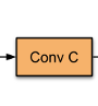

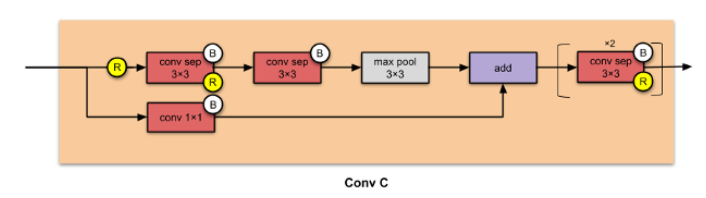

In [123]:
def blockC(x, c = 2):
    residual = tf.keras.layers.Conv2D(1024, (1, 1), strides=(c, c), padding='same', use_bias=False)(x)
    residual = tf.keras.layers.BatchNormalization()(residual)


    x = tf.keras.layers.Activation('relu', name='block13_sepconv1_act')(x)
    x = tf.keras.layers.SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block13_sepconv1')(x)
    x = tf.keras.layers.BatchNormalization(name='block13_sepconv1_bn')(x)

    x = tf.keras.layers.Activation('relu', name='block13_sepconv2_act')(x)
    x = tf.keras.layers.SeparableConv2D(1024, (3, 3), padding='same', use_bias=False, name='block13_sepconv2')(x)
    x = tf.keras.layers.BatchNormalization(name='block13_sepconv2_bn')(x)

    x = tf.keras.layers.MaxPooling2D((3, 3), strides=(c, c), padding='same', name='block13_pool')(x)

    x = tf.keras.layers.add([x, residual])



    x = tf.keras.layers.SeparableConv2D(1536, (3, 3), padding='same', use_bias=False, name='block14_sepconv1')(x)
    x = tf.keras.layers.BatchNormalization(name='block14_sepconv1_bn')(x)
    x = tf.keras.layers.Activation('relu', name='block14_sepconv1_act')(x)

    x = tf.keras.layers.SeparableConv2D(2048, (3, 3), padding='same', use_bias=False, name='block14_sepconv2')(x)
    x = tf.keras.layers.BatchNormalization(name='block14_sepconv2_bn')(x)
    x = tf.keras.layers.Activation('relu', name='block14_sepconv2_act')(x)
    return x

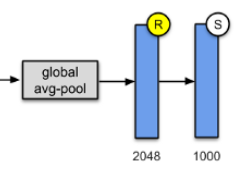

In [124]:
def blockEnd(x, include_top = True, pooling = 'avg', classes=1000):
  
  if include_top:
        x = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)

        x = tf.keras.layers.Dense(classes, activation='softmax', name='predictions')(x)

  else:
        if pooling == 'avg':
            x = tf.keras.layers.GlobalAveragePooling2D()(x)

        elif pooling == 'max':
            x = tf.keras.layers.GlobalMaxPooling2D()(x)
  return x

In [125]:
def Xception():
  
  input_im = tf.keras.layers.Input(shape=img_shape)

  x = tf.keras.layers.ZeroPadding2D(padding=(3, 3))(input_im)

  x = block1(x)
  x = blockA(x)
  x = blockB(x)
  x = blockC(x)
  x = blockEnd(x, include_top = False)

  model = tf.keras.models.Model(input_im, x, name='xception')

  return model

In [126]:
# CREATE FEATURE MODEL

feature_model = Xception()

In [127]:
feature_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 34, 34, 1)   0           ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 16, 16, 64)   576         ['zero_padding2d_1[0][0]']       
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 16, 16, 64)  256         ['block1_conv1[0][0]']    

# Siamese модель

Застосовуємо модель, яка генерує фічі, до обох зображень, а потім об'єднуємо їх разом, щоб
спрогнозувати їх подібність. Ідея моделі є такою:

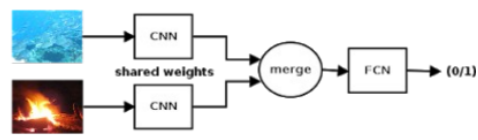

Кінцева ідея полягає в тому, що при отриманні нового зображення можна розрахувати для нього
функціональний вектор за допомогою FeatureGenerationModel. Всі існуючі зображення були
попередньо розраховані і збережені в базі даних векторів-фіч. Модель може бути застосована з
використанням декількох векторних додавань і множень для визначення найбільш схожих растрів. Ці
операції можуть бути реалізовані у вигляді збереженої процедури або всередині самої бази даних.

In [128]:
def SiameseModel():

  img_a_in = tf.keras.layers.Input(shape = img_shape, name = 'ImageA_Input')
  img_b_in = tf.keras.layers.Input(shape = img_shape, name = 'ImageB_Input')

  img_a_feat = feature_model(img_a_in)
  img_b_feat = feature_model(img_b_in)

  combined_features = tf.keras.layers.concatenate([img_a_feat, img_b_feat], name='merge_features')


  combined_features = tf.keras.layers.Dense(16, activation = 'linear')(combined_features)
  combined_features = tf.keras.layers.BatchNormalization()(combined_features)
  combined_features = tf.keras.layers.Activation('relu')(combined_features)

  combined_features = tf.keras.layers.Dense(4, activation = 'linear')(combined_features)
  combined_features = tf.keras.layers.BatchNormalization()(combined_features)
  combined_features = tf.keras.layers.Activation('relu')(combined_features)

  combined_features = tf.keras.layers.Dense(1, activation = 'sigmoid')(combined_features)


  model = tf.keras.Model(inputs = [img_a_in, img_b_in], outputs=[combined_features], name = 'Similarity_Model')

  return model

In [129]:
# CREATE SIMILARITY MODEL

similarity_model = SiameseModel()

In [130]:
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 xception (Functional)          (None, 2048)         20933832    ['ImageA_Input[0][0]',           
                                                                  'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 4096)         0           ['xception[0][0]',

# Training

In [131]:
# DEF PARAMS 

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-1)    #1e-3
lossF = 'binary_crossentropy'
metrics = ['mae']

In [132]:
# SET OPTIMIZER LOSS METRICS

similarity_model.compile(optimizer = optimizer, loss = lossF, metrics = metrics)

In [133]:
# DEF CALLBACKS

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

save_model = tf.keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/Classroom/similarity_model",
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)

In [134]:
# CHECK SHAPES

print("All x data shape: " + str(x_tra.shape)) 

print("\nFirst input x data shape: " + str(x_tra[:,0].shape)) 
print("\nSecond input x data shape: " + str(x_tra[:, 1].shape)) 

print("\nNew all x data shape: " + str(np.shape([x_tra[:,0], x_tra[:, 1]])))

All x data shape: (95984, 2, 28, 28)

First input x data shape: (95984, 28, 28)

Second input x data shape: (95984, 28, 28)

New all x data shape: (2, 95984, 28, 28)


In [137]:
# REWORK DATA REPRESENTATION

xdataTrain = [x_tra[:,0], x_tra[:, 1]]
xdataVal = [x_val[:,0], x_val[:, 1]]

callbacks = [early_stopping, save_model, reduce_lr]

In [138]:
'''xdataTrain = [x_tra[::50,0], x_tra[::50, 1]]
xdataVal = [x_val[::10,0], x_val[::10, 1]]

y_tra = y_tra[::50]
y_val = y_val[::10]'''

In [139]:
# TRAIN MODEL

history = similarity_model.fit(
    xdataTrain,
    y_tra,
    epochs = EPOCH,
    batch_size = BS,
    validation_data = (xdataVal, y_val),
    callbacks = callbacks)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/3
15/15 [==============================] - ETA: 0s - loss: 0.7019 - mae: 0.4993 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/similarity_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/similarity_model/assets


15/15 [==============================] - 473s 32s/step - loss: 0.7019 - mae: 0.4993 - val_loss: 4140652298240.0000 - val_mae: 0.4897 - lr: 0.1000
Epoch 2/3
15/15 [==============================] - ETA: 0s - loss: 0.6806 - mae: 0.4902 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/similarity_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/similarity_model/assets


15/15 [==============================] - 479s 32s/step - loss: 0.6806 - mae: 0.4902 - val_loss: 4395176.0000 - val_mae: 0.4908 - lr: 0.1000
Epoch 3/3
15/15 [==============================] - ETA: 0s - loss: 0.5470 - mae: 0.3872 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/similarity_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/similarity_model/assets


15/15 [==============================] - 381s 25s/step - loss: 0.5470 - mae: 0.3872 - val_loss: 32171.7500 - val_mae: 0.4919 - lr: 0.1000


# Візуалізація результатів

Взявши невелику вибірку випадково вибраних зображень A і B першої половини з однієї і тієї ж
категорії, а другий - з різних категорій, візуалізуємо роботу моделі.
Також виведемо фактичну відстань (0 для тієї ж категорії і 1 для різних категорій), а також
прогнозовану відстань моделі. Перший прогін буде з повністю непідготовленою мережею, тому
значні по якості результати не очікуються.

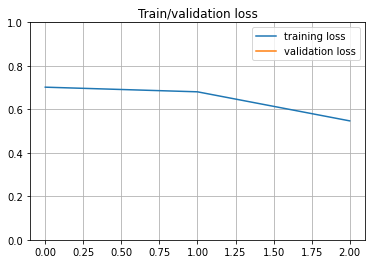

In [141]:
# SHOW TRAIN LOSS HISTORY

def plot_history(history):

    plt.title('Train/validation loss')

    plt.plot(history.history['loss'], label = 'training loss')
    plt.plot(history.history['val_loss'], label = 'validation loss')

    plt.grid()
    plt.legend()
    plt.ylim(0,1)

    plt.show()

plot_history(history)

In [142]:
# DEF SHOW PREDICT RESULTS

def show_model_output(nb_examples = 5):
    pv_a, pv_b, pv_sim  = te_pairs[:nb_examples, 0], te_pairs[:nb_examples, 1], te_y[:nb_examples]

    pred_sim = similarity_model.predict([pv_a, pv_b])

    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))

    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):

        ax1.imshow(c_a)
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')

        ax2.imshow(c_b)
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')

    return fig

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


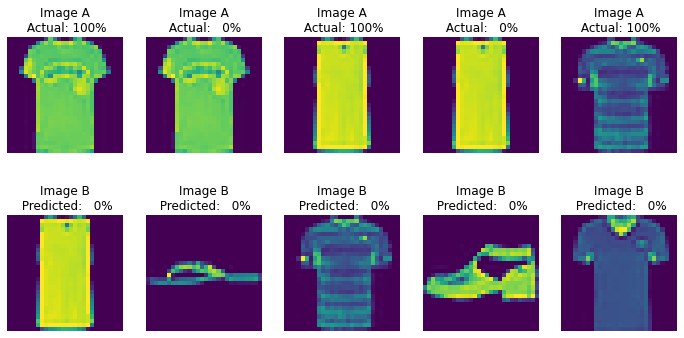

In [143]:
_ = show_model_output()

# T-Shirt vs Ankle Boot-Plot


Беремо випадкові образи футболки і черевика (категорії 0 і 9) і обчислюємо відстань по мережі до
інших образів

In [144]:
# TEST ON TWO EXAMPLES

test_groups = [test_images[np.where(test_labels==i)[0]] for i in np.unique(train_labels)]

t_shirt_vec = np.stack([test_groups[0][0]]*test_images.shape[0], 0)
t_shirt_score = similarity_model.predict([t_shirt_vec, test_images], verbose = True, batch_size = BS) # one to many check


ankle_boot_vec = np.stack([test_groups[9][0]]*test_images.shape[0],0)
ankle_boot_score = similarity_model.predict([ankle_boot_vec, test_images], verbose = True, batch_size = BS) # one to many check

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


79/79 [==============================] - 114s 1s/step


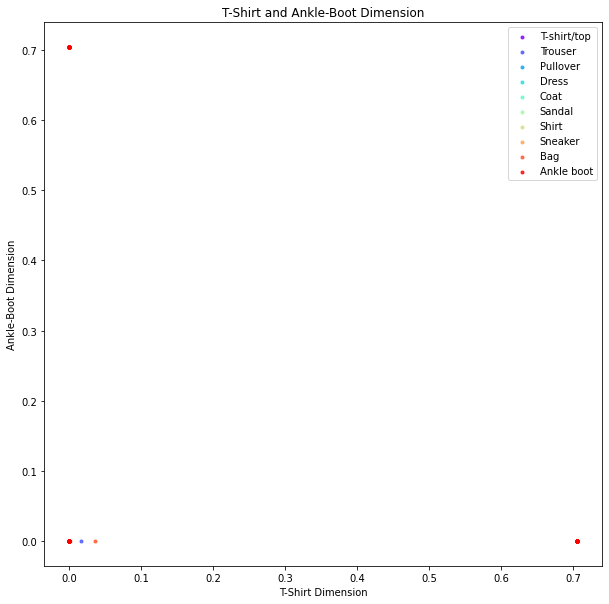

In [145]:
# TEST

obj_categories = ['T-shirt/top','Trouser','Pullover','Dress', 'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
  plt.scatter(
      t_shirt_score[np.where(test_labels == c_group), 0],
      ankle_boot_score[np.where(test_labels == c_group), 0],
      marker='.',
      color=c_color,
      linewidth='1',
      alpha=0.8,
      label=c_label
  )

plt.xlabel('T-Shirt Dimension')
plt.ylabel('Ankle-Boot Dimension')

plt.title('T-Shirt and Ankle-Boot Dimension')
plt.legend(loc='best')

plt.savefig('tshirt-boot-dist.png')

plt.show(block=False)

# Function for similar images search

In [146]:
# DEF FUN TO FIND SIMILAR IMAGE

def find_similar(image, images, count=3, threshold=50):
    pv_a, pv_b = np.reshape([image]*len(images), (len(images), 28,28)), np.reshape(images, (len(images), 28,28))

    pred_sim = similarity_model.predict([pv_a, pv_b]).ravel()

    indxs = np.argsort(pred_sim)[::-1][:count]
    
    fig, m_axs = plt.subplots(2, count, figsize = (12, 6))
    i = 0

    for c_a, (ax1, ax2) in zip(pv_a[:count], m_axs.T):
        
        ax1.imshow(c_a)
        ax1.set_title('Input image\n')
        ax1.axis('off')

        ax2.imshow(pv_b[indxs[i]])
        ax2.set_title('Similar\n Predicted: %3.0f%%' % (100*pred_sim[indxs[i]]))
        ax2.axis('off')
        i += 1

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


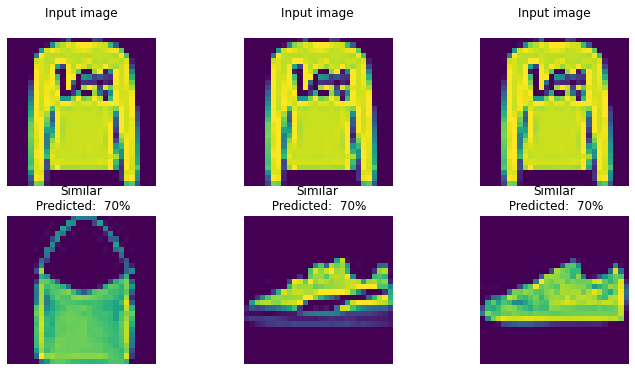

In [147]:
# TEST FUNC

find_similar(test_images[1], images=test_images[1:50])

# Перевірка фічей - t-SNE

Одне із найбільш важливих питань - чи за допомогою моделі Feature Generation генерувались
корисні фічі. І як можна це візуалізувати

In [148]:
# PREDICT DATA FOR TEST

x_test_features = feature_model.predict(test_images, verbose = True, batch_size=BS)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


79/79 [==============================] - 58s 739ms/step


In [149]:
# BUILD TSNE

%%time
from sklearn.manifold import TSNE

tsne_obj = TSNE(n_components=2,
                init='pca',
                random_state=101,
                method='barnes_hut',
                n_iter=500,
                verbose=2)

tsne_features = tsne_obj.fit_transform(x_test_features)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.021s...
[t-SNE] Computed neighbors for 10000 samples in 11.414s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 3495.733181
[t-SNE] Computed conditional probabilities in 0.887s


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Iteration 50: error = 43.6595802, gradient norm = 0.0007097 (50 iterations in 19.394s)
[t-SNE] Iteration 100: error = 42.6898422, gradient norm = 0.0003629 (50 iterations in 19.515s)
[t-SNE] Iteration 150: error = 42.1102448, gradient norm = 0.0002443 (50 iterations in 19.304s)
[t-SNE] Iteration 200: error = 41.7049255, gradient norm = 0.0001873 (50 iterations in 19.158s)
[t-SNE] Iteration 250: error = 41.3948097, gradient norm = 0.0001547 (50 iterations in 19.195s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.394810
[t-SNE] Iteration 300: error = 0.9582207, gradient norm = 0.0001795 (50 iterations in 19.326s)
[t-SNE] Iteration 350: error = 0.9376640, gradient norm = 0.0001574 (50 iterations in 19.035s)
[t-SNE] Iteration 400: error = 0.9116349, gradient norm = 0.0001336 (50 iterations in 19.259s)
[t-SNE] Iteration 450: error = 0.8852128, gradient norm = 0.0001134 (50 iterations in 19.273s)
[t-SNE] Iteration 500: error = 0.8603975, gradient norm = 0.000

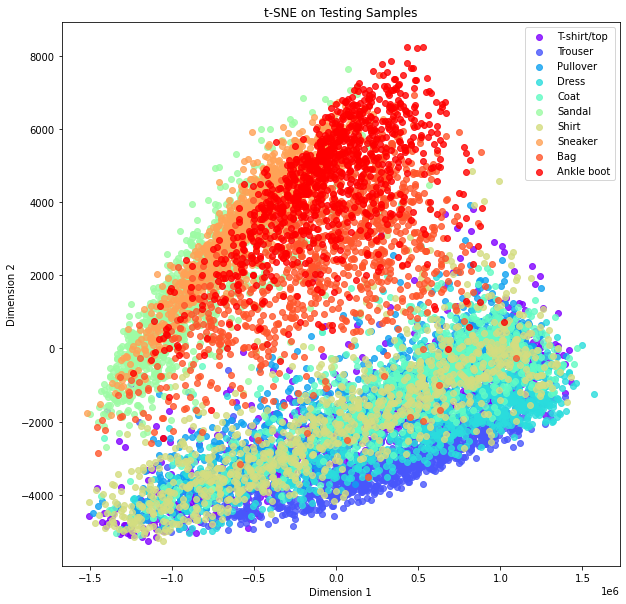

In [150]:
# SHOW T_SNE ON TESTING SAMPLES

obj_categories = ['T-shirt/top','Trouser','Pullover','Dress', 'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

colors = plt.cm.rainbow(np.linspace(0, 1, 10))

plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(test_labels == c_group), 0],
      tsne_features[np.where(test_labels == c_group), 1],
      marker='o',
      color=c_color,
      linewidth='1',
      alpha=0.8,
      label=c_label)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')

plt.savefig('clothes-dist.png')

plt.show(block=False)